In [1]:
from dask_jobqueue import SLURMCluster
import matplotlib.pyplot as plt 
import glob
import os
import xarray as xr 
import pandas as pd
import numpy as np


cluster = SLURMCluster(
    job_name="Climt1",          # --job-name
    cores=46,                   # 24 cores per node
    processes=8,                # One process per task
    memory="120GB",             # --mem
    walltime="01:15:00",        # --time
    queue="med",                # --partition
    log_directory=".",          # Logs will be saved to the current directory
)

from dask.distributed import Client


cluster.scale(jobs=10)
client = Client(cluster)

/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38573 instead
  warnings.warn(


In [2]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:38573/status,
Dashboard: http://10.42.239.61:38573/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:34103,Workers: 0
Dashboard: http://10.42.239.61:38573/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
in_fol = '/home1/nalex2023/Datasets/ERA5_single_maritime/sst_and_t2m_2000_2014/'




dset_era_sst = xr.open_mfdataset(in_fol+'*.nc')


manus_sub_era = dset_era_sst.sel(latitude=slice(-1,-3),longitude=slice(145,148.5)).sel(valid_time=slice('2012-04-01','2012-04-30'))

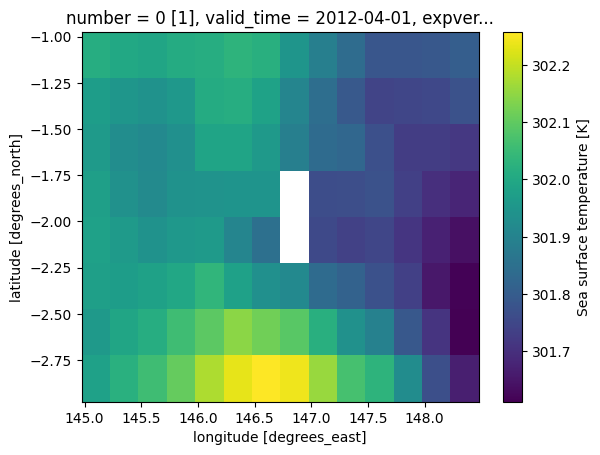

In [4]:
manus_sub_era.isel(valid_time=0).sst.plot()

In [5]:
in_fol = '/home1/nalex2023/Datasets/ERA5_land_maritime/2m_temp_skin_2000_2014/'

dset_era_land = xr.open_mfdataset(in_fol+'*.nc')

manus_sub_land = dset_era_land.sel(latitude=slice(-1,-3),longitude=slice(145,149)).sel(valid_time=slice('2012-04-01','2012-04-30'))

In [6]:
manus_sub_era['sst'] = manus_sub_era['sst'] -273.15

manus_sub_land['t2m'] = manus_sub_land['t2m'] -273.15

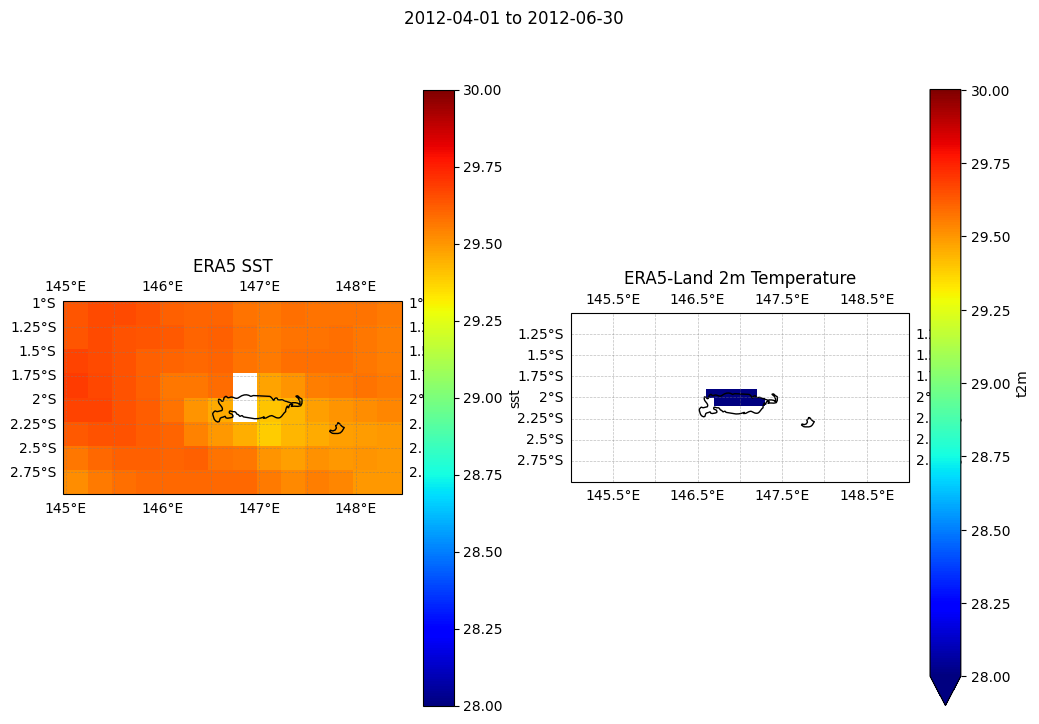

In [7]:


import cartopy.crs as crs

fig,ax = plt.subplots(1,2,figsize=(12,8),subplot_kw={'projection': crs.PlateCarree()})
manus_sub_era.mean(dim='valid_time').sst.plot(transform=crs.PlateCarree(),ax=ax[0],cmap='jet',vmin=28,vmax=30)
#ax.set_extent([145, 148, -3, -0.9], crs=crs.PlateCarree())
# add gridlabels 

ax[0].set_title('ERA5 SST')

manus_sub_land.mean(dim='valid_time').t2m.plot(ax=ax[1],transform=crs.PlateCarree(),cmap='jet',vmin=28,vmax=30)
ax[1].set_title('ERA5-Land 2m Temperature')

fig.suptitle('2012-04-01 to 2012-06-30')

for ii in ax:
    ii.coastlines()
    ii.gridlines(draw_labels=True,linewidth=0.5, color='gray', alpha=0.5, linestyle='--')


In [8]:



land_temp_east_dropped = manus_sub_land.dropna(dim='latitude',how='all').dropna(dim='longitude',how='all')#.sel(latitude=-2,longitude=147.5,method='nearest').t2m

#land_temp_east_point = land_temp_east_dropped.sel(latitude=-2,longitude=147,method='nearest').t2m

land_temp_whole = land_temp_east_dropped.t2m.mean(dim=['latitude','longitude'])

sst_temp_east_dropped = manus_sub_era.dropna(dim='latitude',how='all').dropna(dim='longitude',how='all')

sst_temp_whole = sst_temp_east_dropped.sel(latitude=-2.1,longitude=147.1,method='nearest').sst

#sst_temp_whole = sst_temp_east_dropped.sst.sel(latitude=slice(-1.75,-2.75),longitude=slice(147.5,148.5)).mean(dim=['latitude','longitude'])

def convert_solar(x,lon):
    """
    Convert UTC time to local solar time
    """
    return x + pd.Timedelta(hours=lon/15)

land_temp_whole['valid_time'] = convert_solar(land_temp_whole['valid_time'],lon=147.5)

In [9]:
sst_temp_whole

<xarray.DataArray 'sst' (valid_time: 720)> Size: 3kB
dask.array<getitem, shape=(720,), dtype=float32, chunksize=(720,), chunktype=numpy.ndarray>
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 6kB 2012-04-01 ... 2012-04-30T23:...
    latitude    float64 8B -2.1
    longitude   float64 8B 147.1
    expver      (valid_time) <U4 12kB dask.array<chunksize=(720,), meta=np.ndarray>

In [10]:
sst_temp_east_dropped

<xarray.Dataset> Size: 663kB
Dimensions:     (valid_time: 720, latitude: 8, longitude: 14)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 6kB 2012-04-01 ... 2012-04-30T23:...
  * latitude    (latitude) float64 64B -1.1 -1.35 -1.6 ... -2.35 -2.6 -2.85
  * longitude   (longitude) float64 112B 145.1 145.3 145.6 ... 147.8 148.1 148.3
    expver      (valid_time) <U4 12kB dask.array<chunksize=(720,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 323kB dask.array<chunksize=(720, 8, 14), meta=np.ndarray>
    sst         (valid_time, latitude, longitude) float32 323kB dask.array<chunksize=(720, 8, 14), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-14T15:47 GRIB to CDM+CF via cfgrib-0.9.1...

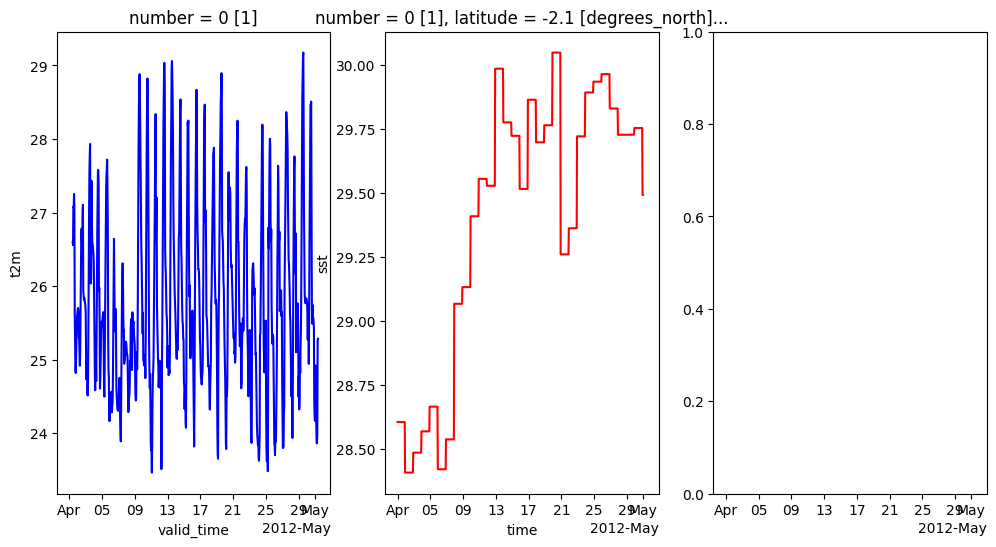

In [11]:
fig,ax = plt.subplots(1,3,figsize=(12,6),sharex=True)

land_temp_whole.plot(ax=ax[0],label='ERA5-Land 2m Temperature',color='blue')
sst_temp_whole.plot(ax=ax[1],label='ERA5 SST',color='red')




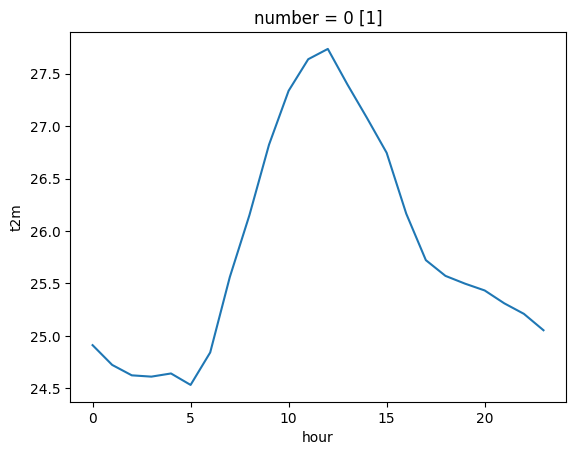

In [12]:
# diurnal UTC

land_temp_whole_diurnal = land_temp_whole.groupby('valid_time.hour').mean()

land_temp_whole_diurnal.plot()

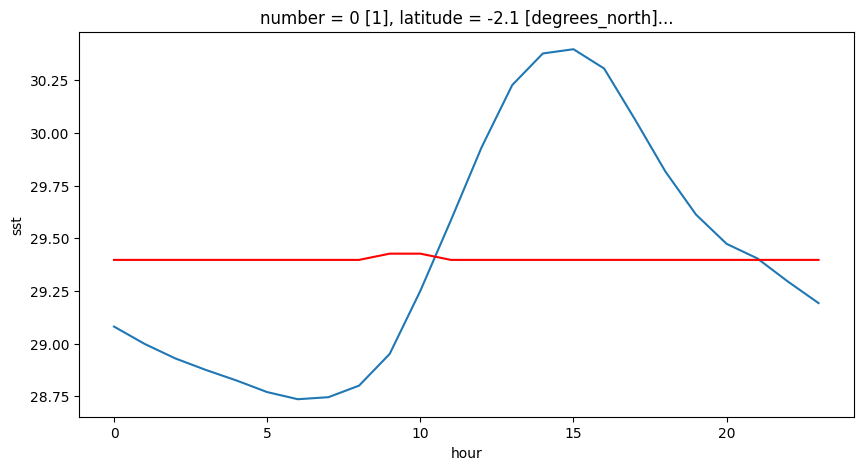

In [13]:
buoy_data = pd.read_fwf('https://tao.ndbc.noaa.gov/refreshed/cache/dm028a_WATER_TEMPERATURE_1121820250415192318251762589.txt',
                        sep=' ')

buoy_data['Date/Time'] = pd.to_datetime(buoy_data['Date/Time'], format='%Y-%m-%d %H:%M:%S')

buoy_data_sorted = buoy_data.sort_values(by='Date/Time')

# shift the time by 10 hours to match the local time

def convert_solar(x,lon):
    """
    Convert UTC time to local solar time
    """
    return x + pd.Timedelta(hours=lon/15)

buoy_data_sorted['Date/Time'] = buoy_data_sorted['Date/Time'].apply(lambda x: convert_solar(x, 165))


buoy_data_hourly = buoy_data_sorted.set_index('Date/Time').resample('h').mean()
buoy_data_hourly['hour'] = buoy_data_hourly.index.hour

buoy_data_hourly['anom'] = buoy_data_hourly['Value'] - buoy_data_hourly['Value'].mean()


buoy_diurnal = buoy_data_hourly.groupby('hour').mean()

#buoy_diurnal['anom'].plot(color='blue', label='Buoy Data')


diurnal_pattern_norm = buoy_diurnal['anom'] / np.max(np.abs(buoy_diurnal['anom']))

sst_temp_whole['valid_time']  = convert_solar(sst_temp_whole['valid_time'], 165)



sst_era_diurnal = sst_temp_whole.groupby('valid_time.hour').mean() 

sst_era_new = sst_era_diurnal + 1*diurnal_pattern_norm

fig,ax = plt.subplots(1,1,figsize=(10,5))
sst_era_new.plot(ax=ax)
sst_era_diurnal.plot(ax=ax,label='ERA5 SST Diurnal Cycle',color='red')

<Axes: xlabel='hour'>

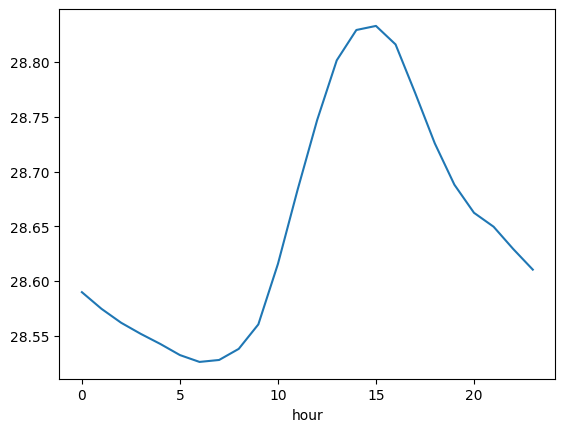

In [14]:
buoy_diurnal['Value'].plot()

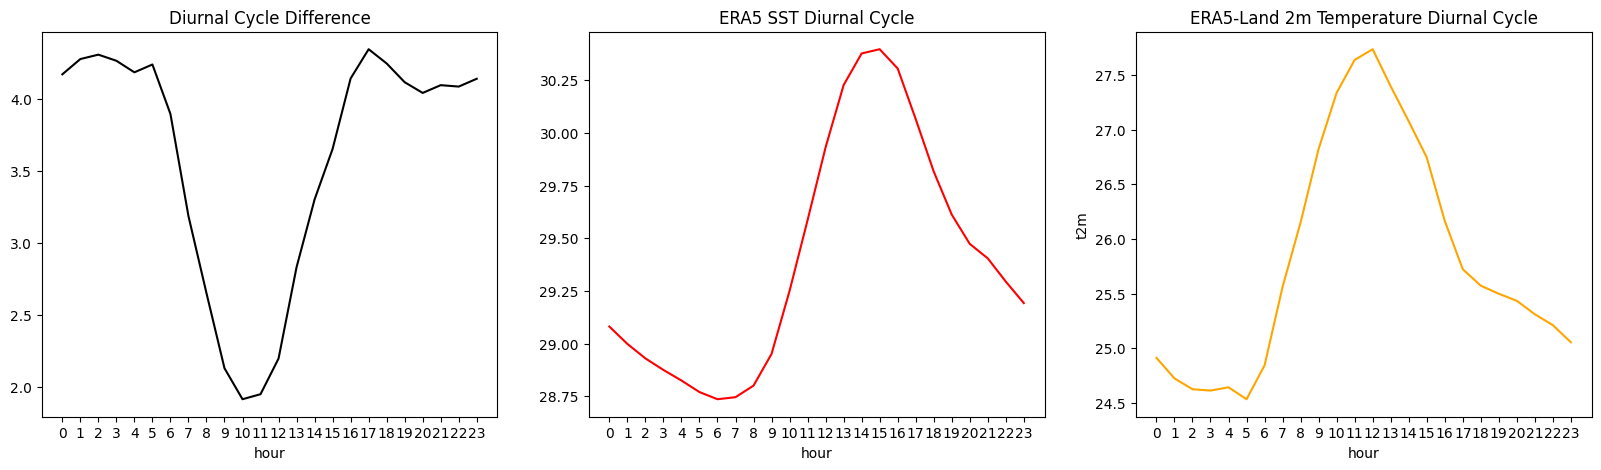

In [15]:
diff_diurnal = abs(land_temp_whole_diurnal - sst_era_new)

fig,ax = plt.subplots(1,3,figsize=(20,5),sharex=True)
diff_diurnal.plot(ax=ax[0],label='Diurnal Cycle Difference',color='black')
sst_era_new.plot(ax=ax[1],label='ERA5 SST Diurnal Cycle',color='red')
land_temp_whole_diurnal.plot(ax=ax[2],label='ERA5-Land 2m Temperature Diurnal Cycle',color='orange')

ax[0].set_title('Diurnal Cycle Difference')
ax[1].set_title('ERA5 SST Diurnal Cycle')
ax[2].set_title('ERA5-Land 2m Temperature Diurnal Cycle')

for ii in ax:
    ii.set_xticks(np.arange(0, 24, 1))
    ii.set_xticklabels(np.arange(0, 24, 1), rotation=0)